<a href="https://colab.research.google.com/github/Scoince/Random-Code-Practise/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics
import cv2
import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path

# ====================== Object Detection System ======================
# Train on annotated data and detect from video/webcam
# Supports YOLO format annotations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Step 1: Create the Dataset Structure

This will create the necessary directories (`dataset/images/train`, `dataset/images/val`, `dataset/labels/train`, `dataset/labels/val`) and a template `data.yaml` file. Run this cell first.

In [9]:
create_sample_dataset_structure()

Dataset structure created!
Place your images in dataset/images/train and dataset/images/val
Place corresponding label files in dataset/labels/train and dataset/labels/val

Label format (one object per line):
class_id center_x center_y width height
(all values normalized 0-1)


### Step 2: Populate Your Dataset Directories

**Before proceeding, you must manually upload your training and validation images and their corresponding YOLO-format label files to the directories created in Step 1.**

*   Place your training images in `dataset/images/train/`
*   Place your validation images in `dataset/images/val/`
*   Place your training label `.txt` files in `dataset/labels/train/`
*   Place your validation label `.txt` files in `dataset/labels/val/`

Also, **edit the `dataset/data.yaml` file** to reflect your actual class names (replace 'person', 'car', 'dog' with your custom class names).

### Step 3: Train the YOLO Model

Once your dataset is prepared and uploaded, uncomment the code below and run this cell to start training your custom YOLO model. You can adjust the `epochs`, `img_size`, and `batch_size` parameters as needed.

In [10]:
# Uncomment the lines below to train your model after preparing your dataset in the previous steps
# trained_model = train_model(
#     data_yaml_path='dataset/data.yaml',
#     epochs=50, # Adjust number of epochs as needed
#     img_size=640,
#     batch_size=16 # Adjust batch size based on your GPU memory
# )

### Dataset Preparation and Training Functions

This section contains functions to set up your dataset in the YOLO format and to train a new YOLO model using that data.

In [3]:
def create_sample_dataset_structure():
    """
    Creates sample dataset folder structure for YOLO format

    Expected structure:
    dataset/
    ├── images/
    │   ├── train/
    │   └── val/
    ├── labels/
    │   ├── train/
    │   └── val/
    └── data.yaml
    """
    dirs = [
        'dataset/images/train',
        'dataset/images/val',
        'dataset/labels/train',
        'dataset/labels/val'
    ]

    for d in dirs:
        Path(d).mkdir(parents=True, exist_ok=True)

    # Create data.yaml
    yaml_content = """
# Train/val sets
path: ./dataset  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: person
  1: car
  2: dog
# Add your custom classes here
"""

    with open('dataset/data.yaml', 'w') as f:
        f.write(yaml_content)

    print("Dataset structure created!")
    print("Place your images in dataset/images/train and dataset/images/val")
    print("Place corresponding label files in dataset/labels/train and dataset/labels/val")
    print("\nLabel format (one object per line):")
    print("class_id center_x center_y width height")
    print("(all values normalized 0-1)")

# Uncomment the line below to create the dataset structure if you haven't already
# create_sample_dataset_structure()

In [4]:
def train_model(data_yaml_path, epochs=50, img_size=640, batch_size=16):
    """
    Train YOLO model on annotated data

    Args:
        data_yaml_path: Path to data.yaml file (contains dataset info)
        epochs: Number of training epochs
        img_size: Input image size
        batch_size: Batch size for training
    """
    # Load pretrained YOLOv8 model (nano version for faster training)
    model = YOLO('yolov8n.pt')

    # Train the model
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        patience=10,  # Early stopping
        save=True,
        device='cuda:0',  # Use 'cpu' if no GPU
        project='runs/detect',
        name='custom_model'
    )

    print(f"Training complete! Model saved to: runs/detect/custom_model/weights/best.pt")
    return model

# Uncomment the lines below to train your model after preparing your dataset
# trained_model = train_model(
#     data_yaml_path='dataset/data.yaml',
#     epochs=50,
#     img_size=640,
#     batch_size=16
# )

### Object Detection Inference Class

This class provides methods to perform object detection using a trained YOLO model from a webcam, video file, or single image.

In [5]:
class VideoDetector:
    def __init__(self, model_path='yolov8n.pt', conf_threshold=0.5):
        """
        Initialize detector

        Args:
            model_path: Path to trained model weights
            conf_threshold: Confidence threshold for detections
        """
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold

    def detect_from_webcam(self, camera_id=0, show_fps=True):
        """
        Real-time detection from webcam

        Args:
            camera_id: Camera device ID (0 for default webcam)
            show_fps: Whether to display FPS
        """
        cap = cv2.VideoCapture(camera_id)

        if not cap.isOpened():
            print(f"Error: Cannot open camera {camera_id}")
            return

        print("Press 'q' to quit")

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            # Run detection
            results = self.model(frame, conf=self.conf_threshold, verbose=False)

            # Visualize results
            annotated_frame = results[0].plot()

            # Show FPS
            if show_fps:
                # cap.get(cv2.CAP_PROP_FPS) can return 0 if camera doesn't report it
                # A better way for real-time FPS is to calculate it based on time elapsed
                # For simplicity, using a placeholder or actual if available
                fps = cap.get(cv2.CAP_PROP_FPS) # This might be 0 or incorrect for live stream
                if fps > 0: # Check if a valid FPS is returned by the camera
                    cv2.putText(annotated_frame, f'FPS: {int(fps)}', (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                else:
                    cv2.putText(annotated_frame, 'FPS: N/A', (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cv2.imshow('Object Detection', annotated_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    def detect_from_video(self, video_path, output_path=None, show_display=True):
        """
        Detect objects in video file

        Args:
            video_path: Path to input video
            output_path: Path to save output video (optional)
            show_display: Whether to display video while processing
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Cannot open video {video_path}")
            return

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Setup video writer if output path specified
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
            writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        print(f"Processing video: {total_frames} frames at {fps} FPS")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection
            results = self.model(frame, conf=self.conf_threshold, verbose=False)
            annotated_frame = results[0].plot()

            # Save frame if output specified
            if writer:
                writer.write(annotated_frame)

            # Display
            if show_display:
                cv2.imshow('Video Detection', annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"Processed {frame_count}/{total_frames} frames")

        cap.release()
        if writer:
            writer.release()
            print(f"Output saved to: {output_path}")
        cv2.destroyAllWindows()

    def detect_image(self, image_path, save_path=None):
        """
        Detect objects in a single image

        Args:
            image_path: Path to input image
            save_path: Path to save annotated image (optional)
        """
        # Run detection
        results = self.model(image_path, conf=self.conf_threshold)

        # Visualize
        annotated_img = results[0].plot()

        # Save if specified
        if save_path:
            cv2.imwrite(save_path, annotated_img)
            print(f"Saved to: {save_path}")

        # Display
        # Note: In Colab, cv2.imshow will not work directly. You'd typically save the image
        # and display it or convert it to a format displayable in a Colab output cell.
        # For local execution, this will open a window.
        # cv2.imshow('Detection Result', annotated_img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # If running in Colab and want to see the image, you might use matplotlib or PIL
        import matplotlib.pyplot as plt
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Print detections
        print("\n--- Detections ---")
        if len(results[0].boxes) == 0:
            print("No objects detected.")
        for box in results[0].boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = results[0].names[cls]
            print(f"Detected: {class_name} (confidence: {conf:.2f})")

### Usage Examples for `VideoDetector`

Here are examples demonstrating how to use the `VideoDetector` class for different inference tasks. Uncomment the code within each cell to run a specific example.

In [6]:
# Example 1: Detect from Webcam (Requires a local camera and interactive environment)

# Option A: Use a pretrained YOLO model (detects 80 common objects)
detector_pretrained = VideoDetector(model_path='yolov8n.pt', conf_threshold=0.5)

# Option B: Use your custom-trained model (uncomment after training and replace with your model path)
# detector_custom = VideoDetector(model_path='runs/detect/custom_model/weights/best.pt', conf_threshold=0.5)

# Uncomment to run webcam detection
# Note: This usually requires a local setup with a webcam and cannot run directly in a standard Colab environment.
# If you're running this code locally, uncomment the line below:
# detector_pretrained.detect_from_webcam(camera_id=0)

In [7]:
# Example 2: Detect from Video File

# Make sure you have an 'input_video.mp4' file uploaded to your Colab environment
# You can also use a URL to a video file, e.g., 'https://youtu.be/...' or a path to a video in Google Drive
# For testing, you might need to upload a sample video file.

# If you used the pretrained detector in the previous cell, you can reuse it.
# Otherwise, initialize a new detector:
# detector_video = VideoDetector(model_path='yolov8n.pt', conf_threshold=0.5)

# Uncomment and provide a valid video path to run video detection
# detector_pretrained.detect_from_video('input_video.mp4', output_path='output_video.mp4', show_display=True)

In [8]:
# Example 3: Detect from Image File

# Make sure you have an 'image.jpg' file uploaded to your Colab environment
# For testing, you might need to upload a sample image file.

# If you used the pretrained detector in previous cells, you can reuse it.
# Otherwise, initialize a new detector:
# detector_image = VideoDetector(model_path='yolov8n.pt', conf_threshold=0.5)

# Uncomment and provide a valid image path to run image detection
# detector_pretrained.detect_image('image.jpg', save_path='detected_image.jpg')

In [11]:
import cv2

# Load the video file
video = cv2.VideoCapture('people_walking.mp4')

# Load the pre-trained full body Haar Cascade
# You need the 'haarcascade_fullbody.xml' file in your directory
body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

# Set the minimum size for detection (adjust based on video resolution)
min_size = (30, 60)

while True:
    # Read a frame from the video
    ret, frame = video.read()
    if not ret:
        break

    # Resize frame for faster processing
    frame_resized = cv2.resize(frame, (800, 480))

    # Convert to grayscale (Haar Cascades work better in gray)
    gray_frame = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    gray_blurred = cv2.GaussianBlur(gray_frame, (5, 5), 0)

    # Detect humans in the frame
    bodies = body_cascade.detectMultiScale(gray_blurred, 1.1, 3, minSize=min_size)

    # Draw rectangles around detected humans
    for (x, y, w, h) in bodies:
        cv2.rectangle(frame_resized, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the output
    cv2.imshow('People Detection', frame_resized)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

#OPENCV

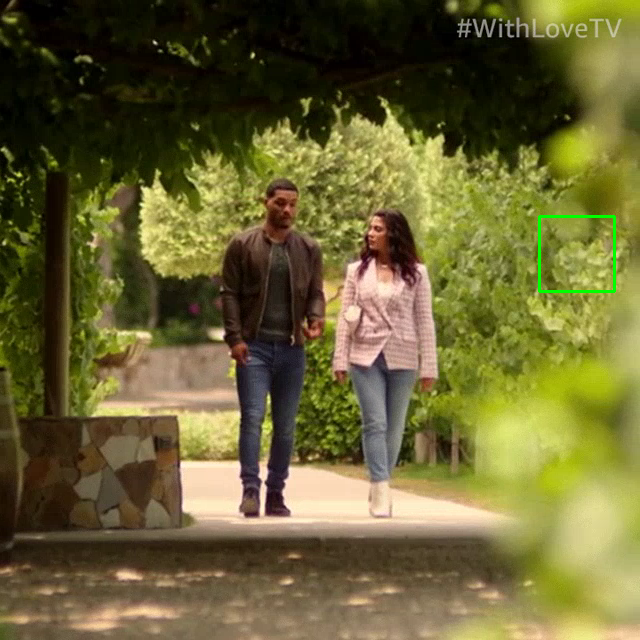

End of video stream.
Detection process finished.


In [7]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# 1. Load the pre-trained Face Cascade
path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(path)

# Check if the cascade classifier loaded successfully
if face_cascade.empty():
    print("Error: Could not load Haar cascade classifier.")
    exit()

# 2. Upload your video file first!
# Go to the folder icon on the left -> Right Click -> Upload
# Make sure the filename matches exactly below.
video_path = 'people_walking.mp4'
video_cap = cv2.VideoCapture(video_path)

if not video_cap.isOpened():
    print(f"Error: Cannot open video source '{video_path}'.")
    print("TIP: Make sure you uploaded the file to the session storage.")
    exit()

print("Processing video... Press the 'Stop' button to interrupt.")

while True:
    # Read frame-by-frame
    ret, video_data = video_cap.read()

    # Break the loop if reading the frame failed (End of video)
    if not ret:
        print("End of video stream.")
        break

    # Convert to Grayscale
    col = cv2.cvtColor(video_data, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        col,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw rectangles
    for (x, y, w, h) in faces:
        cv2.rectangle(video_data, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # --- COLAB SPECIFIC DISPLAY CODE ---
    # Instead of cv2.imshow, we use cv2_imshow
    # We use clear_output so the images stack in place (like a video)
    clear_output(wait=True)
    cv2_imshow(video_data)
    # ----------------------------------

# Release resources
video_cap.release()
print("Detection process finished.")

#YOLO

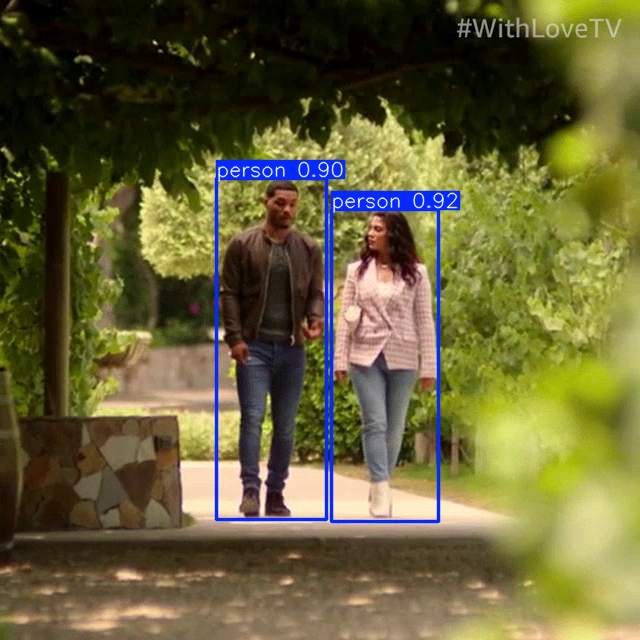

End of video stream.

Detection process finished!


In [6]:
"""
YOLO Object Detection in Google Colab
Similar structure to Haar Cascade but with YOLO for better detection
"""

# First, install ultralytics (run this cell once)
# !pip install ultralytics

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from ultralytics import YOLO

# 1. Load the pre-trained YOLO model
print("Loading YOLO model...")
model = YOLO('yolov8n.pt')  # 'n' = nano (fastest), also try 's', 'm', 'l', 'x' for better accuracy
print("Model loaded successfully!")

# Print available classes
print(f"\nThis model can detect {len(model.names)} object classes:")
print("Classes:", list(model.names.values()))

# 2. Upload your video file first!
# Go to the folder icon on the left -> Right Click -> Upload
# Make sure the filename matches exactly below.
video_path = 'people_walking.mp4'
video_cap = cv2.VideoCapture(video_path)

if not video_cap.isOpened():
    print(f"Error: Cannot open video source '{video_path}'.")
    print("TIP: Make sure you uploaded the file to the session storage.")
    exit()

# Get video properties
fps = int(video_cap.get(cv2.CAP_PROP_FPS))
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"\nProcessing video: {total_frames} frames at {fps} FPS")
print("Press the 'Stop' button to interrupt.\n")

frame_count = 0
conf_threshold = 0.5  # Confidence threshold (0.0 to 1.0)

while True:
    # Read frame-by-frame
    ret, video_data = video_cap.read()

    # Break the loop if reading the frame failed (End of video)
    if not ret:
        print("End of video stream.")
        break

    # Run YOLO detection on the frame
    results = model(video_data, conf=conf_threshold, verbose=False)

    # Get the annotated frame with bounding boxes
    annotated_frame = results[0].plot()

    # Optional: Print detected objects every 30 frames
    frame_count += 1
    if frame_count % 30 == 0:
        detected_objects = []
        for box in results[0].boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = model.names[cls]
            detected_objects.append(f"{class_name} ({conf:.2f})")

        if detected_objects:
            print(f"Frame {frame_count}: Detected: {', '.join(detected_objects)}")

    # --- COLAB SPECIFIC DISPLAY CODE ---
    # Instead of cv2.imshow, we use cv2_imshow
    # We use clear_output so the images stack in place (like a video)
    clear_output(wait=True)
    cv2_imshow(annotated_frame)
    # ----------------------------------

# Release resources
video_cap.release()
print("\nDetection process finished!")